# SENSOR DATA ANALYZER
### Objectives of this project is to create a model that can:

* Detect anomalies in machine sensor readings that indicate unusual behavior or potential faults.

### Dataset used:
* Kaggle dataset: Machine Failure Prediction using Sensor data
  Link: https://www.kaggle.com/datasets/umerrtx/machine-failure-prediction-using-sensor-data/data


### Dataset Columns:
* footfall: The number of people or objects passing by the machine.
* tempMode: The temperature mode or setting of the machine.
* AQ: Air quality index near the machine.
* USS: Ultrasonic sensor data, indicating proximity measurements.
* CS: Current sensor readings, indicating the electrical current usage of the machine.
* VOC: Volatile organic compounds level detected near the machine.
* RP: Rotational position or RPM (revolutions per minute) of the machine parts.
* IP: Input pressure to the machine.
* Temperature: The operating temperature of the machine.
* fail: Binary indicator of machine failure (1 for failure, 0 for no failure).


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score, classification_report, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from sklearn.preprocessing import PowerTransformer

## Exploartory Data Description

In [2]:
df = pd.read_csv('drive/MyDrive/Sensor Data Analyzer/sensor_data/data.csv')

In [3]:
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
0,0,7,7,1,6,6,36,3,1,1
1,190,1,3,3,5,1,20,4,1,0
2,31,7,2,2,6,1,24,6,1,0
3,83,4,3,4,5,1,28,6,1,0
4,640,7,5,6,4,0,68,6,1,0


In [4]:
df.tail()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
939,0,7,7,1,6,4,73,6,24,1
940,0,7,5,2,6,6,50,6,24,1
941,0,3,6,2,7,5,43,6,24,1
942,0,6,6,2,5,6,46,7,24,1
943,18,7,4,2,6,3,61,7,24,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   footfall     944 non-null    int64
 1   tempMode     944 non-null    int64
 2   AQ           944 non-null    int64
 3   USS          944 non-null    int64
 4   CS           944 non-null    int64
 5   VOC          944 non-null    int64
 6   RP           944 non-null    int64
 7   IP           944 non-null    int64
 8   Temperature  944 non-null    int64
 9   fail         944 non-null    int64
dtypes: int64(10)
memory usage: 73.9 KB


In [6]:
df.isna().sum()

,0
footfall,0
tempMode,0
AQ,0
USS,0
CS,0
VOC,0
RP,0
IP,0
Temperature,0
fail,0


There are no missing values

In [7]:
df.describe()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail
count,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000,944.000000
mean,306.381356,3.727754,4.325212,2.939619,5.394068,2.842161,47.043432,4.565678,16.331568,0.416314
std,1082.606745,2.677235,1.438436,1.383725,1.269349,2.273337,16.423130,1.599287,5.974781,0.493208
min,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,19.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,3.000000,2.000000,5.000000,1.000000,34.000000,3.000000,14.000000,0.000000
50%,22.000000,3.000000,4.000000,3.000000,6.000000,2.000000,44.000000,4.000000,17.000000,0.000000
75%,110.000000,7.000000,6.000000,4.000000,6.000000,5.000000,58.000000,6.000000,21.000000,1.000000
max,7300.000000,7.000000,7.000000,7.000000,7.000000,6.000000,91.000000,7.000000,24.000000,1.000000


## Exploratory Data Analysis

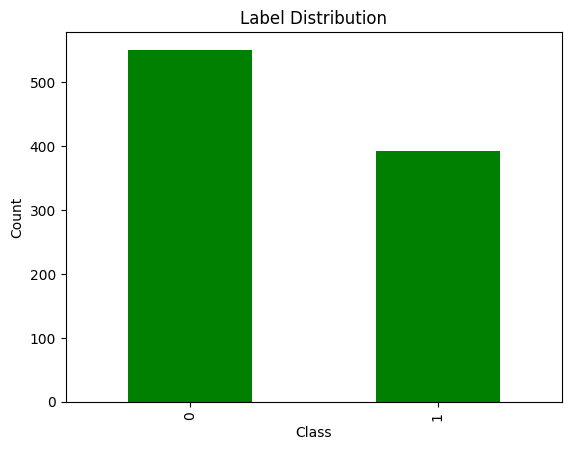

In [8]:
# Label distribution
df['fail'].value_counts().plot(kind='bar', color = "green")
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

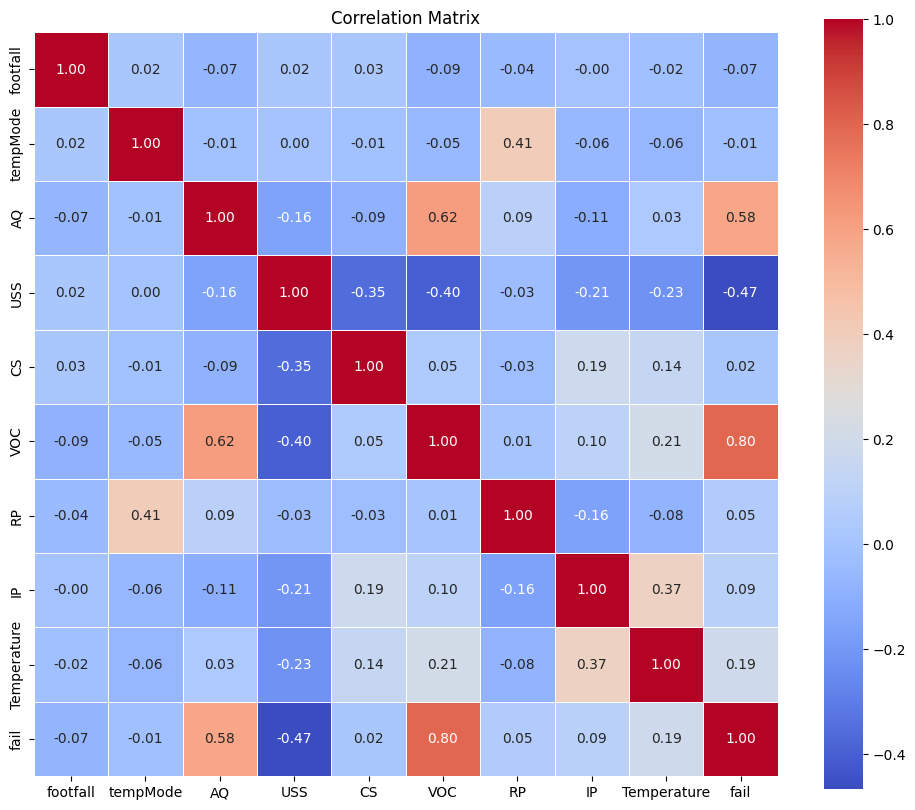

In [9]:
# Correlation matrix
df_corr = df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(df_corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

### Visualize and solve for outliers using capping and flooring

In [10]:
X = df.drop("fail", axis = 1)
y = df["fail"]

In [11]:
# Splitting the dataset

from sklearn.model_selection import train_test_split

np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2)

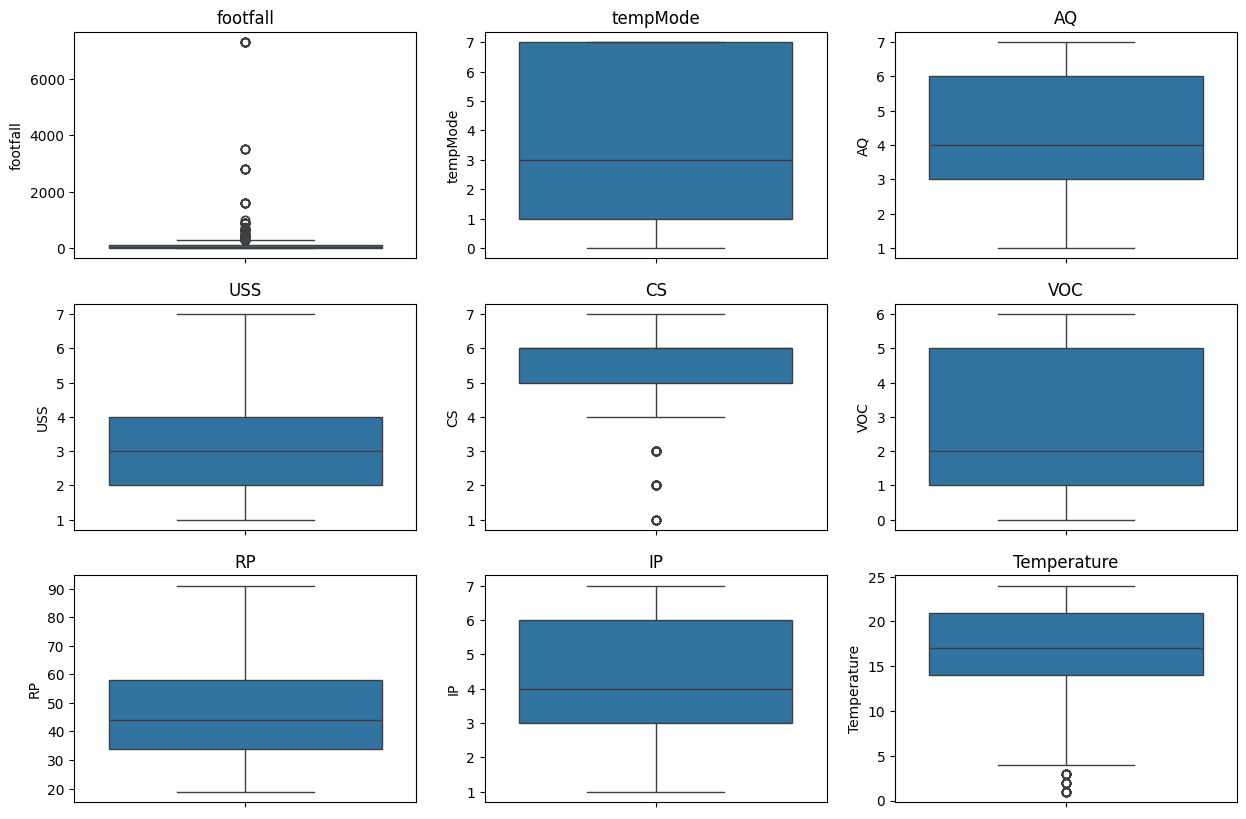

In [12]:
# Visualize the outliers in each column using boxplot

plt.figure(figsize = (15, 10))
for i, col in enumerate(X_train):
  plt.subplot(3,3, i+1)
  sns.boxplot(df[col])
  plt.title(col)
plt.show()

**footfall** – Spikes in human/object traffic are normal.

**CS (Current Sensor)** :
Low values could mean:
* Machine was turned off
* Circuit malfunction
* Sensor failed

**Temperature**:
Very low values could mean:
* Faulty temperature sensor
* The machine was cooled too much
* A potential hardware issue


----------------------------------------------------------------

### Showing the relationship between the failure and each column

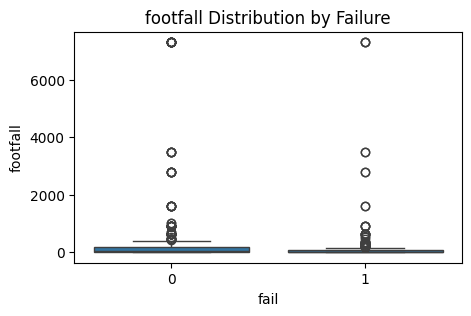

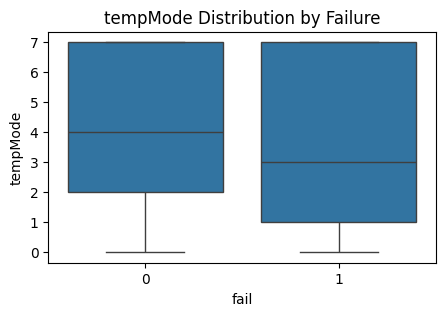

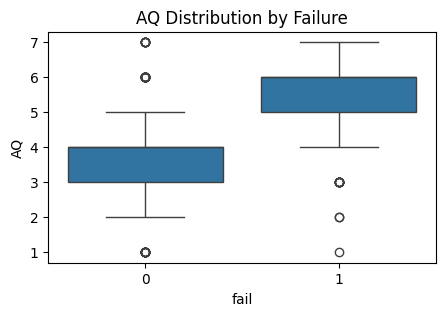

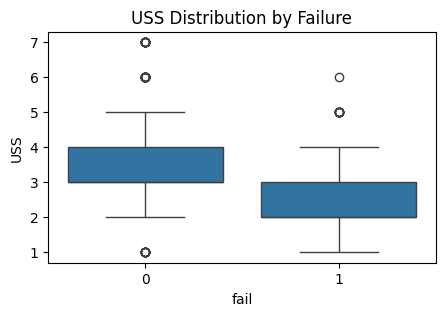

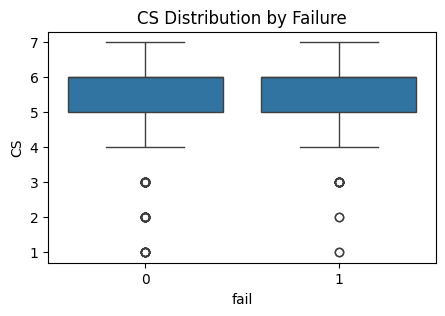

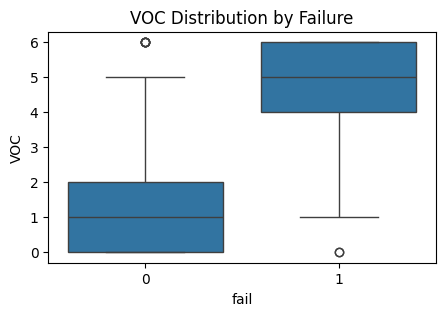

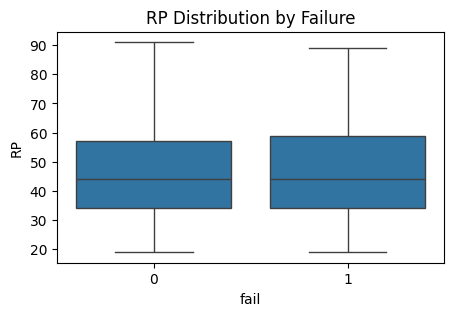

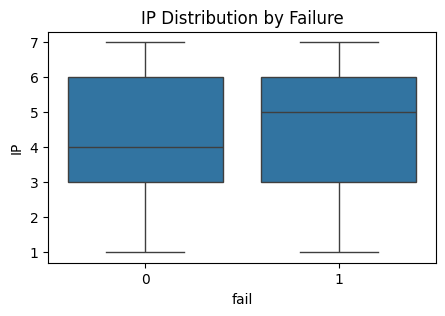

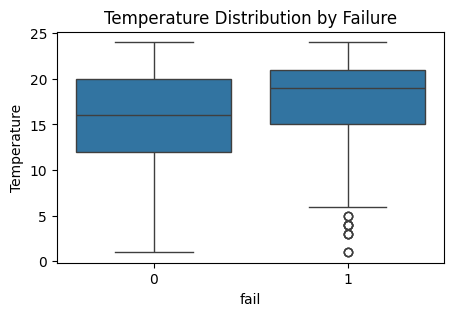

In [13]:
for col in X_train.columns:
  plt.figure(figsize = (5, 3))
  sns.boxplot(x=y_train, y=X_train[col])
  plt.title(f'{col} Distribution by Failure')
  plt.show()


I won’t cap or floor temperature because its extreme values occur mainly during machine failures, making them important signals for detecting anomalies.

In [14]:
### Using capping and flooring to remove outliers

cols_to_cap_floor = ['AQ', 'CS', 'USS', 'footfall', 'VOC']

# Create a copy of the original data for comparison
original = X_train[cols_to_cap_floor].copy()

# Compute thresholds
caps = {}
floors = {}
for col in cols_to_cap_floor:
    floors[col] = original[col].quantile(0.05)
    caps[col]   = original[col].quantile(0.95)

# Apply clipping
for col in cols_to_cap_floor:
    X_train[col] = X_train[col].clip(lower=floors[col], upper=caps[col])

# Now compare original vs clipped to count how many changed
for col in cols_to_cap_floor:
    was_too_low  = (original[col] < floors[col]).sum()
    was_too_high = (original[col] > caps[col]).sum()
    print(f"{col}: values below floor = {was_too_low}, values above cap = {was_too_high}")


AQ: values below floor = 16, values above cap = 25
CS: values below floor = 34, values above cap = 0
USS: values below floor = 0, values above cap = 14
footfall: values below floor = 0, values above cap = 30
VOC: values below floor = 0, values above cap = 0


I applied capping and flooring to AQ, CS, USS, footfall, and VOC. But some values were 0. This shows there were no extreme values outside the main range, and the few outliers are likely genuine anomalies that could be important for the model to detect.

`Note:` I did not clean outliers for test data because I want the model to be tested on real-world messy data, not just cleaned data.

---

### Skewness Transformation

#### For train data

In [15]:
train_skew = X_train.skew()
train_skew

,0
footfall,2.919092
tempMode,-0.037965
AQ,-0.215147
USS,0.623686
CS,-0.804350
VOC,0.175133
RP,0.535789
IP,0.017667
Temperature,-0.909092


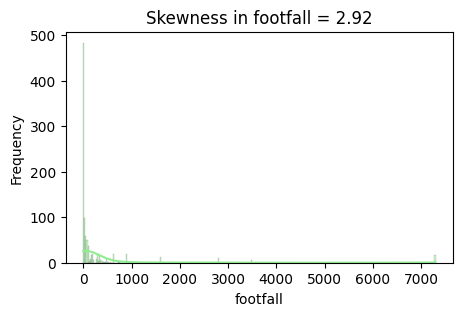

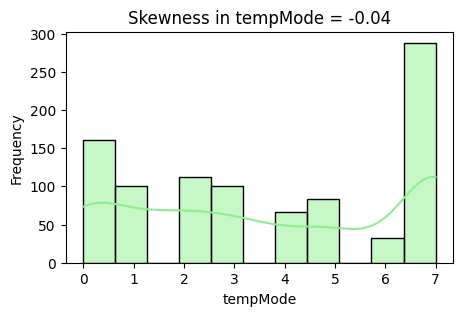

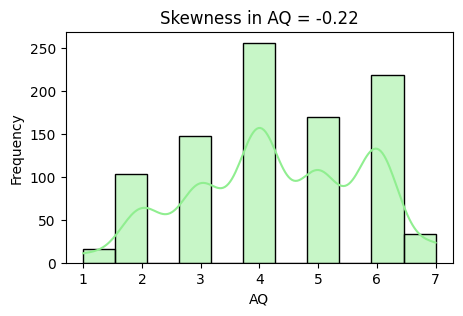

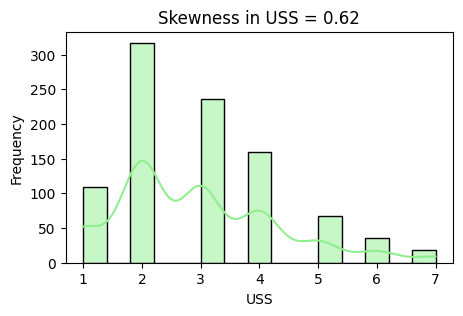

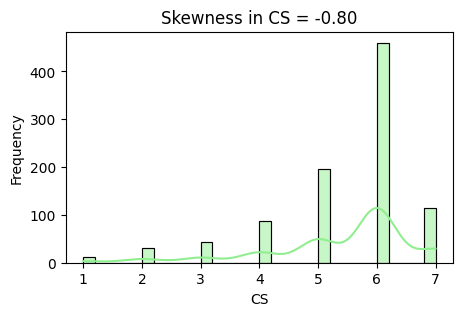

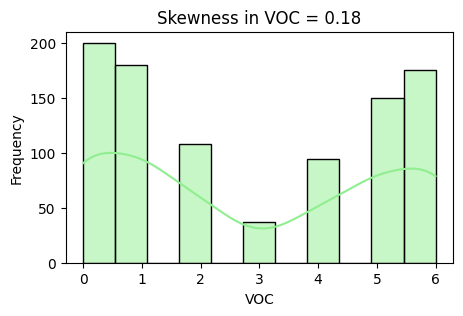

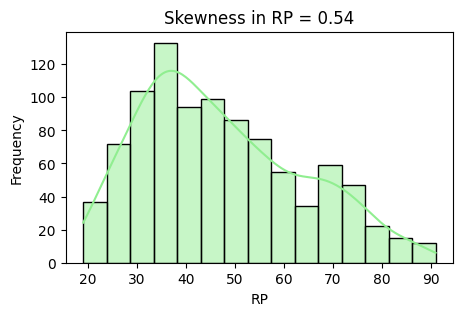

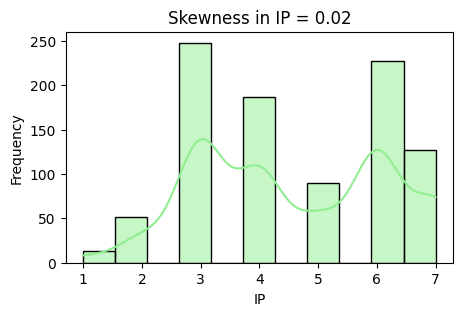

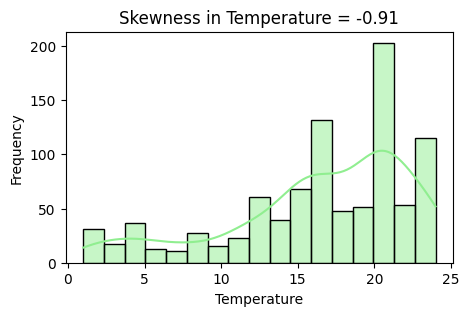

In [16]:
# Skewness for train data
for col in X_train.columns:
    skewness = X_train[col].skew()
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], kde=True, color='lightgreen')
    plt.title(f'Skewness in {col} = {skewness :.2f}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


**Applying skewness transformation using Yeo-Johnson**

I used Yeo-Johnson because it works on both positive and negative values without needing to shift the data, making it safer and more flexible for real-world sensor datasets.

In [17]:
cols_to_transform = [ col for col in X_train.columns if abs(df[col].skew()) > 0.5]
cols_to_transform

['footfall', 'USS', 'CS', 'RP', 'Temperature']

In [18]:
# Create transformer
pt = PowerTransformer(method='yeo-johnson')

# Fit and transform
Xtrain_transformed = X_train.copy()
Xtrain_transformed[cols_to_transform] = pt.fit_transform(X_train[cols_to_transform])


In [19]:
# # Save transformer
# joblib.dump(pt, 'yeojohnson_transformer.pkl')

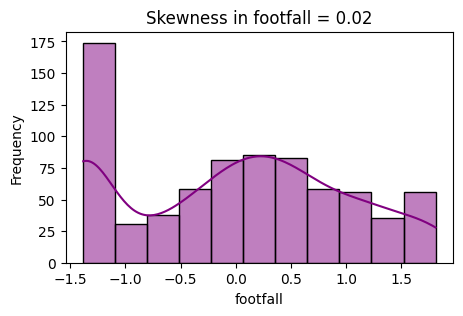

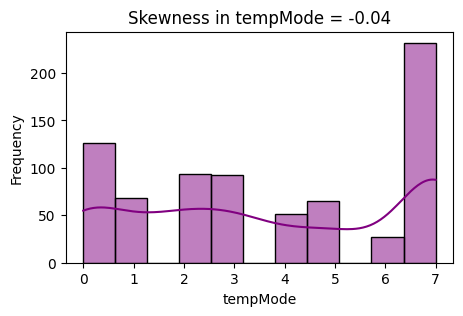

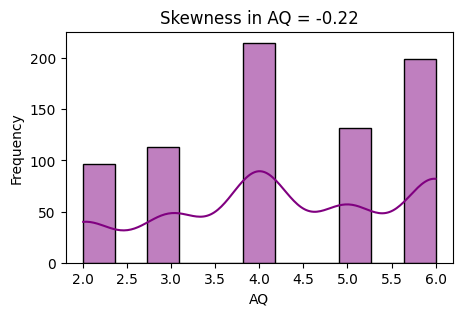

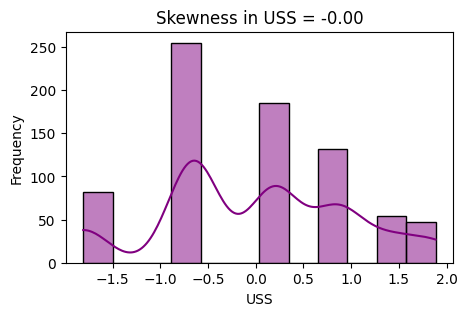

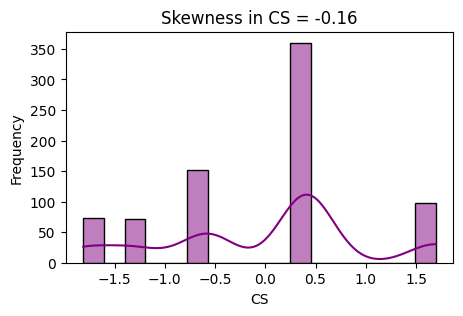

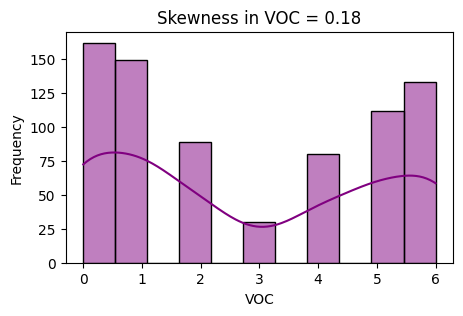

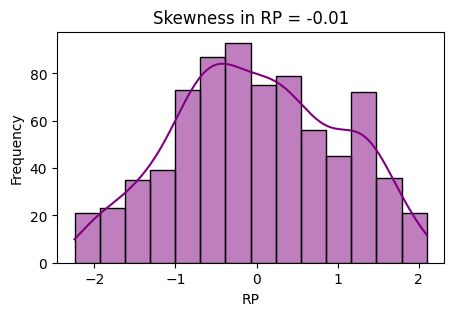

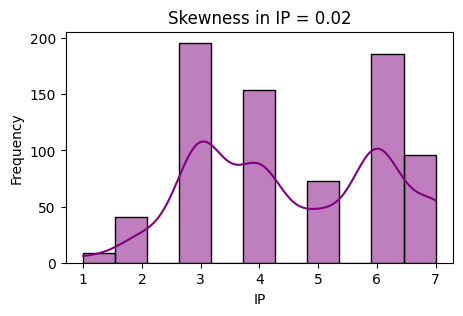

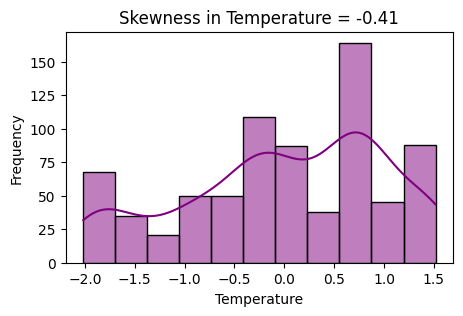

In [20]:
# Visualize the skewness of transformed X_train
for col in Xtrain_transformed.columns:
  plt.figure(figsize=(5, 3))
  sns.histplot(Xtrain_transformed[col], kde=True, color='purple')
  plt.title(f'Skewness in {col} = {Xtrain_transformed[col].skew() :.2f}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

-------------------------------------------

#### Test data

In [21]:
train_skew = X_test.skew()
train_skew

,0
footfall,6.318725
tempMode,0.062092
AQ,-0.090862
USS,0.926270
CS,-1.584930
VOC,-0.077294
RP,0.474328
IP,0.005211
Temperature,-0.933727


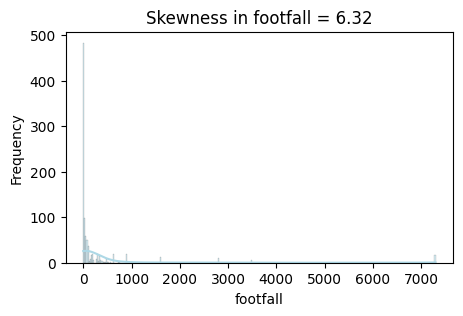

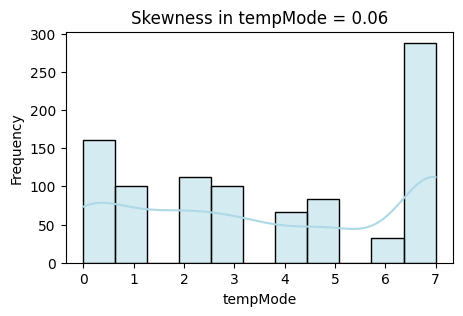

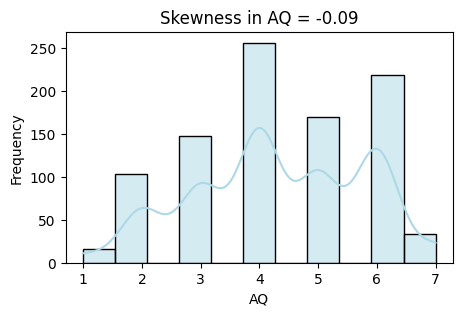

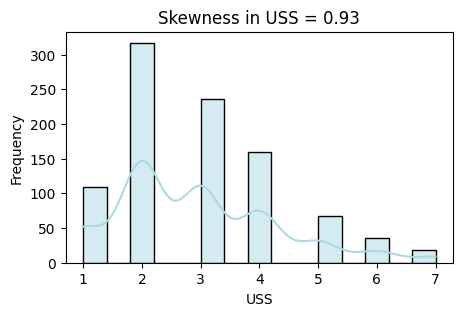

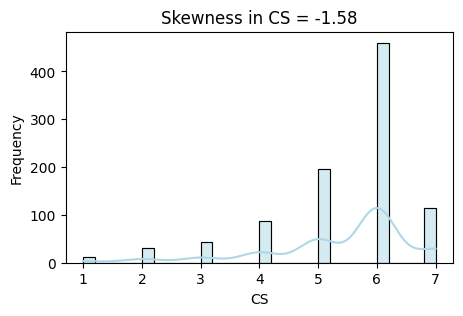

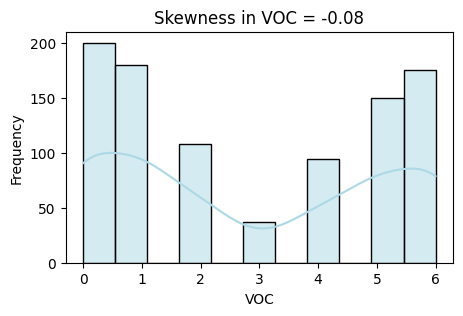

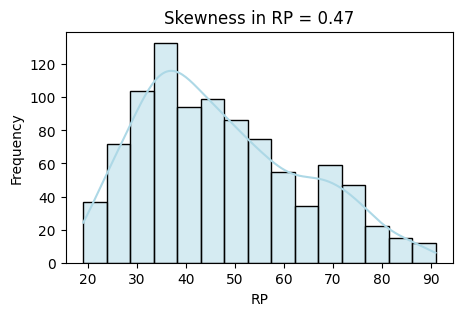

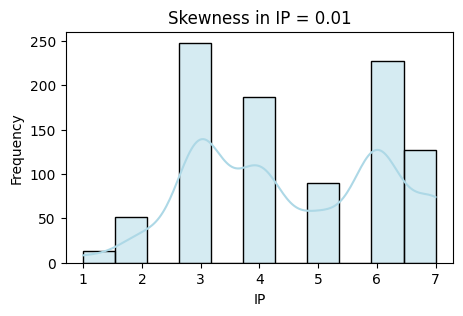

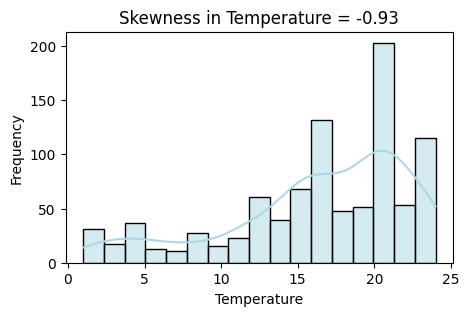

In [22]:
# Skewness of test data
for col in X_test.columns:
    skewness = X_test[col].skew()
    plt.figure(figsize=(5, 3))
    sns.histplot(df[col], kde=True, color='lightblue')
    plt.title(f'Skewness in {col} = {skewness :.2f}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


**Applying skewness transformation using Yeo-Johnson**

In [23]:
# Transform only
Xtest_transformed = X_test.copy()
Xtest_transformed[cols_to_transform] = pt.transform(X_test[cols_to_transform])


Transform test data using the same fitted transformer to avoid leaking the test data

Because the model will be trained on transformed data it expects input in that same distribution during testing or prediction.

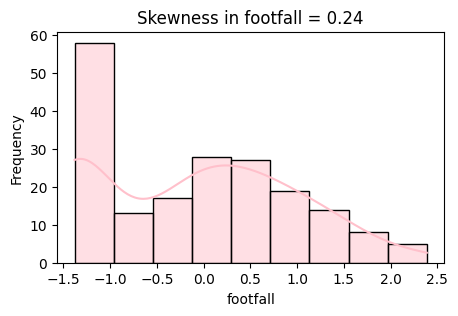

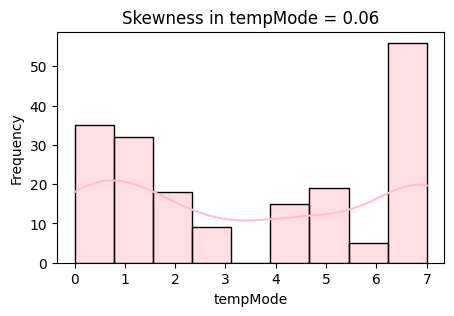

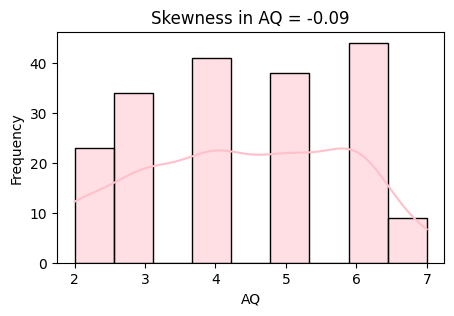

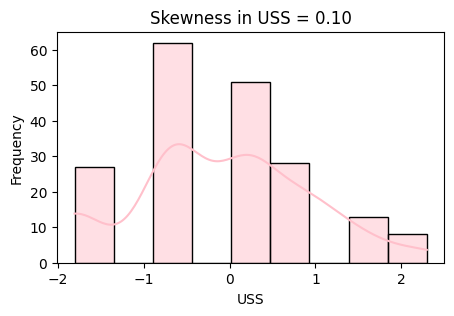

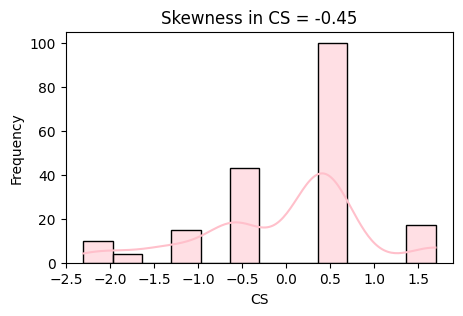

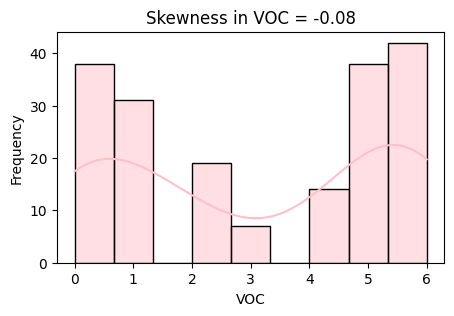

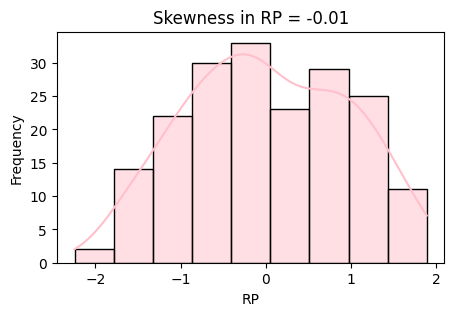

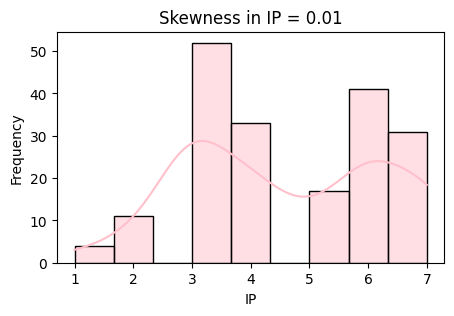

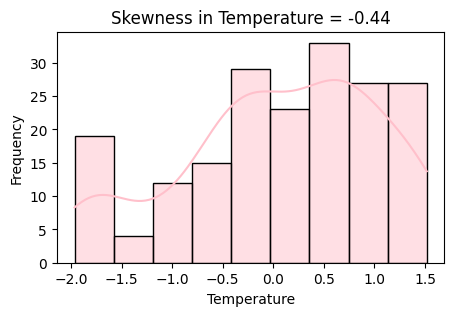

In [24]:
# Visualize the skewness of df_transformed
for col in Xtest_transformed.columns:
  plt.figure(figsize=(5, 3))
  sns.histplot(Xtest_transformed[col], kde=True, color='pink')
  plt.title(f'Skewness in {col} = {Xtest_transformed[col].skew() :.2f}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()

---
---

## Data Preprocessing

### Noise detection and handling
* Noise means random errors, fluctuations, or irrelevant variations in sensor readings.
* It can be caused by sensor faults, environmental interference, or transmission errors.
* Noise can mask true anomalies or create false alarms.

For noise filtering , i will use `median filtering`:
* My goal is to detect true anomalies (outliers) that signal machine faults.
* Median filtering reduces random noise (small jitter) that can confuse your model.
* It keeps genuine fault signals intact, so anomaly detection remains accurate.

In [25]:
sensor_cols = ['tempMode', 'AQ', 'USS', 'CS', 'VOC', 'RP', 'IP', 'Temperature']

`Rolling std dev` captures local fluctuations and noise, which might not be obvious from overall std dev. This helps detect noisy sensor signals.


In [26]:
# std dev
train_stats = Xtrain_transformed[sensor_cols].agg("std").transpose()

# Rolling std dev with window=5 (average rolling std per column)
train_rolling_std = Xtrain_transformed[sensor_cols].rolling(window=5).std().mean()

train_stats['rolling_std_mean'] = train_rolling_std

print(train_stats)


tempMode                                                     2.655598
AQ                                                            1.34201
USS                                                          1.000663
CS                                                           1.000663
VOC                                                           2.25371
RP                                                           1.000663
IP                                                           1.578777
Temperature                                                  1.000663
rolling_std_mean    tempMode       2.559758
AQ             1.29266...
dtype: object


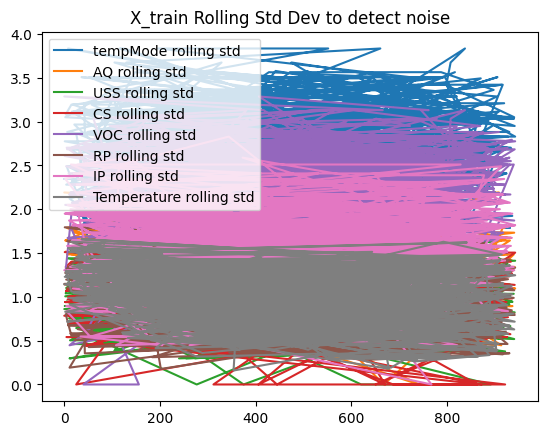

In [27]:
# Visualize rolling standard deviation
for col in sensor_cols:
    train_rolling_std =  Xtrain_transformed[col].rolling(window=5).std()
    plt.plot(train_rolling_std, label=f'{col} rolling std')

plt.legend()
plt.title('X_train Rolling Std Dev to detect noise')
plt.show()


* Columns like tempMode (rolling_std 2.66) and VOC (2.25) have relatively high rolling std, indicating notable short-term variability — these could need noise filtering.
* AQ (1.34) and IP (1.58) also show some variability, will also need noise filtering
* Columns like USS, CS, RP, and  Temperature have low rolling std, so they appear stable and don’t need filtering.



#### Using median filtering

In [28]:
train_cols_to_filter = ['tempMode', 'AQ', 'VOC', 'IP']
window_size = 3
Xtrain_filtered =   Xtrain_transformed.copy()
for col in train_cols_to_filter:
    med_filtered = Xtrain_transformed[col].rolling(window=window_size, center=True).median()
    # Fill NaNs at edges with original values
    med_filtered = med_filtered.fillna(Xtrain_transformed[col])
    Xtrain_filtered[col] = med_filtered

In [29]:
# Checking the rolling std after filtering
filt_stats = Xtrain_filtered[sensor_cols].agg("std").transpose()

rolling_std = Xtrain_filtered[sensor_cols].rolling(window=5).std().mean()

filt_stats['rolling_std_mean'] = rolling_std

print(filt_stats)


tempMode                                                     2.331873
AQ                                                           1.079197
USS                                                          1.000663
CS                                                           1.000663
VOC                                                          1.923441
RP                                                           1.000663
IP                                                           1.261556
Temperature                                                  1.000663
rolling_std_mean    tempMode       1.741790
AQ             0.82307...
dtype: object


Median filtering has reduced random noise but likely kept meaningful variations for anomaly detection.

----

In [30]:
Xtrain_filtered.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature
244,0.054550,3.0,6.0,-1.808995,0.411069,5.0,-1.260305,4.0,-0.541373
82,-1.380692,6.0,5.0,0.193378,0.411069,5.0,2.099204,2.0,-1.738365
316,-1.380692,6.0,5.0,0.193378,0.411069,5.0,1.038056,2.0,-0.367483
350,-0.314618,7.0,5.0,-1.808995,-1.305880,5.0,1.666881,3.0,-0.186147
465,-1.380692,7.0,5.0,-0.649819,-1.305880,4.0,0.435299,7.0,0.002487


In [31]:
Xtest_transformed.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature
96,-0.078445,7,5,0.193378,0.411069,5,1.780043,3,-1.641282
265,0.198577,3,4,0.193378,0.411069,2,-1.168249,7,-0.541373
811,0.407940,4,6,0.193378,-0.577105,6,1.217284,3,1.050668
23,-1.380692,7,6,-1.808995,0.411069,6,-0.037224,4,-1.965076
30,1.204573,0,3,0.859536,1.693903,2,-1.453102,2,-1.965076


---
---

### Applying scaler
I am scaling to ensure that all features contribute equally to the model by putting them on the same scale.

Scaling makes sure the model treats all features fairly

#### Train data

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(Xtrain_filtered)

X_train_scaled = scaler.transform(Xtrain_filtered)

#### Test data

In [33]:
X_test_scaled = scaler.transform(Xtest_transformed)

In [34]:
# # Save the scaler
# joblib.dump(scaler, "scaler.pkl")

 Test data is put on the same scale without leaking any test information into the training pipeline.










In [35]:
# Checking the number of values in each label
y_train.value_counts()

,count
fail,
0,449
1,306


In [36]:
y_test.value_counts()

,count
fail,
0,102
1,87


This distribution is fairly balanced

## Model creation

## Creating sequence with a sliding window for LSTM autoencoder

I need to convert flat data into these overlapping sequences because LSTMs learn from time patterns, not isolated points. This step is called `creating sliding windows`.

In [37]:
# Prepare sequences and labels
def create_sequences_and_labels(data, labels, window_size=10, anomaly_threshold=5):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - window_size + 1):
        seq = data[i:i+window_size]
        label_window = labels[i:i+window_size]
        label = 1 if np.sum(label_window) >= anomaly_threshold else 0
        sequences.append(seq)
        sequence_labels.append(label)
    return np.array(sequences), np.array(sequence_labels)

In [38]:
# Create sequences
X_train_seq, y_train_seq = create_sequences_and_labels(X_train_scaled, y_train, window_size=10)
X_test_seq, y_test_seq = create_sequences_and_labels(X_test_scaled, y_test, window_size=10)

In [39]:
# Splitting the data using train_test_split for training and validation
X_train_main, X_val, y_train_main, y_val = train_test_split(
    X_train_seq, y_train_seq, test_size=0.15, random_state=42, stratify=y_train_seq
)

## Build the model

In [40]:
# Build Supervised LSTM Model
timesteps = X_train_seq.shape[1]
features = X_train_seq.shape[2]

input_layer = Input(shape=(timesteps, features))

x = LSTM(64, return_sequences=True, activation='relu', kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = Dropout(0.3)(x)
x = LSTM(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.3)(x)

output_layer = Dense(1, activation='sigmoid')(x)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


## Train the model

In [41]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True)

In [42]:
# Train the model
history = model.fit(
    X_train_main, y_train_main,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.5415 - loss: 0.7775 - val_accuracy: 0.6518 - val_loss: 0.6847
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6728 - loss: 0.6386 - val_accuracy: 0.7232 - val_loss: 0.5591
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8157 - loss: 0.5409 - val_accuracy: 0.8661 - val_loss: 0.3880
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8348 - loss: 0.4418 - val_accuracy: 0.8839 - val_loss: 0.3389
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8343 - loss: 0.4141 - val_accuracy: 0.8839 - val_loss: 0.3264
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8501 - loss: 0.3922 - val_accuracy: 0.8661 - val_loss: 0.3157
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8620 - loss: 0.3609 - val_accuracy: 0.8839 - val_loss: 0.2997
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8691 - loss: 0.3479 - val_accuracy: 0.8750 - v

## Evaluate the model

In [43]:
# Evaluation on test data
y_pred_prob = model.predict(X_test_seq)

precision, recall, thresholds = precision_recall_curve(y_test_seq, y_pred_prob)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print("Best threshold:", best_threshold)



y_pred = (y_pred_prob > best_threshold).astype(int)



# Metrics
print("\n✅ Classification Report:")
print(classification_report(y_test_seq, y_pred, zero_division=0))



6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step
Best threshold: 0.7961719

✅ Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        94
           1       0.87      0.85      0.86        86

    accuracy                           0.87       180
   macro avg       0.87      0.87      0.87       180
weighted avg       0.87      0.87      0.87       180



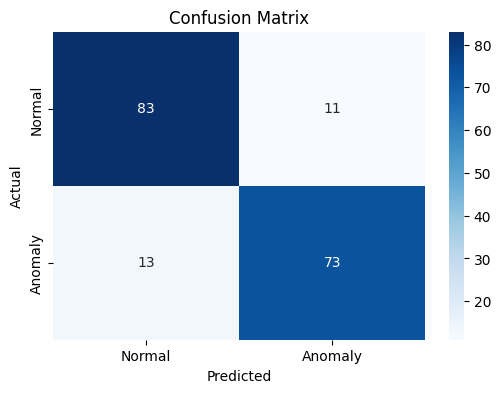

In [47]:
# Confusion Matrix
cm = confusion_matrix(y_test_seq, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

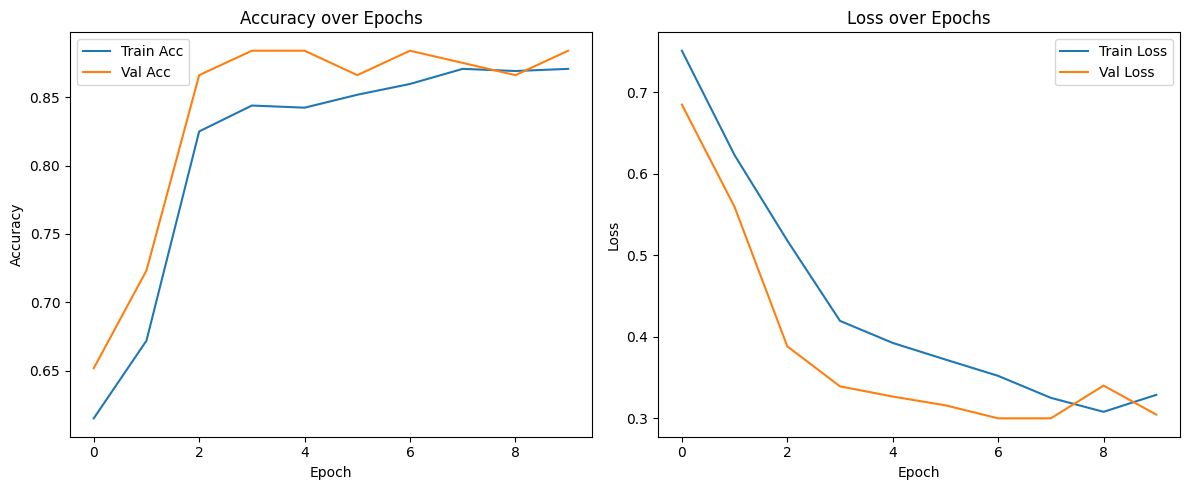

In [48]:
# Plot Accuracy and Loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Save the model

In [46]:
# # save model
# model.save('sensor_lstm_model.keras')